# Movies Recommendation System with Item-Based Collaborative Filtering Approach


## Check List

- [x] Import Libraries
- [x] Read the dataset
- Data Preprocessing
    - [x] Merge Movies and Ratings tables
    - [x] Compress Sparesed Rows - Convert data to csr matrix
- Feature Extraction
    - [x] Choose the features
- Model Training
    - [x] Train KNN with K = 11 (10 simmilar movies + the movie itself) on the training data
- Model Testing
    - [x] Recommendation function
    - [x] Test with different movies names
- Model Saving
    - [x] Save the model using Pickle
- Test The Saved Model
    - [x] Load the dumped model
    - [x] Use the model to predict

## Import Libraries

In [1]:
# Preprocessing
import os
import pandas as pd
import numpy as np

# Training
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model Saving
import pickle

## Read The Dataset

In [2]:
root = os.path.join('..', 'ml-latest-small')

movies_df = pd.read_csv(os.path.join(root, "movies.csv"))
ratings_df = pd.read_csv(os.path.join(root, "ratings.csv"))

In [3]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [4]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


## Data Preprocessing

In [5]:
dataset = ratings_df.pivot(index='movieId',columns='userId',values='rating')
dataset.fillna(0,inplace=True)
dataset.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
no_user_voted = ratings_df.groupby('movieId')['rating'].agg('count')
no_movies_voted = ratings_df.groupby('userId')['rating'].agg('count')

In [7]:
dataset = dataset.loc[no_user_voted[no_user_voted > 10].index,:]
dataset = dataset.loc[:,no_movies_voted[no_movies_voted > 50].index]
dataset.head()

userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [8]:
csr_data = csr_matrix(dataset.values)
dataset.reset_index(inplace=True)


In [28]:
print(csr_data[0, 0])

4.0


## Model Training - KNN with K = 20 and Cosine Simmilarity

In [90]:
def trainKNN(k, data):
    knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
    knn.fit(data)
    
    return knn

In [91]:
k = 20
knn = trainKNN(k, csr_data)

## Model Testing

### Recommendation Function

In [147]:
def Recommend(model, movieName, n):
    """
        Recommend:          Recommends the closes n movies from the output of a KNN model trained on the MovieLens dataset.
        movieName (str):    The movie name required to get the closest n movies to.
        n (int):            The number of movies to get.
    """
    
    n += 1

    # get all movies conatins the movieName
    movies = movies_df[movies_df['title'].str.contains(movieName)]  

    # if there isn't any movie with "movieName"
    if len(movies) < 1:
        return str(movieName) + " movie doesn't exist in our data"

    # get the index of the first result
    movie_id = movies.iloc[0]['movieId']
    movie_index = dataset[dataset['movieId'] == movie_id].index[0]
    
    # get the name of the target movie
    target_movie = movies_df[movies_df['title'].str.contains(movieName)].iloc[0]
    target_movie = target_movie['title']
    
    
    # get the indices of the closest n neighbors from the results on the knn model
    # the indices are the movies positions in the dataset
    distances, indices = model.kneighbors(csr_data[movie_index],n_neighbors=n)    
    
    # sort the output of the knn
    closest_movie_indices = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    
    movies_to_recommend = []

    

    # get the movie name and add it to a list 
    for movie_prediction in reversed(closest_movie_indices):
        index = movie_prediction[0]
        distance = movie_prediction[1]

        # get the movie index
        movie_id = dataset.iloc[index]['movieId']
        movie_index = movies_df[movies_df['movieId'] == movie_id].index
        
        # get the movie name by movie index
        movie_name = movies_df.iloc[movie_index]['title'].values[0]
        
        # add movie name and distance from the original movie to the list
        movies_to_recommend.append({'Movie Name': movie_name,
                                    'Distance': distance})
       
    # create a data frame from the list
    df = pd.DataFrame(movies_to_recommend)

    return df, distances, indices, target_movie

In [159]:
def vis(x, y, data):
    
    plt.scatter(x, y)
    plt.xlabel("Indix")
    plt.ylabel("Distance")
    plt.scatter(x[0],y[0], c ="green", s=50)

    for i, txt in enumerate(data):
        plt.annotate(txt, (x[i], y[i]))
    for i in range(len(x)):
        x_, y_ = [x[0], x[i]], [y[0], y[i]]
        plt.plot(x_, y_)
    
    plt.show()

Movie: Iron Man (2008)
(21,) (21,)
['Iron Man (2008)', 'Avengers,', 'Dark', 'WALL·E', 'Iron', 'Avatar', 'Batman', 'Star', 'Watchmen', 'Guardians', 'Up', 'Inception', 'Kung', 'District', 'Sherlock', 'X-Men:', 'Pirates', 'Thor', 'Pirates', 'Pirates', 'Star']


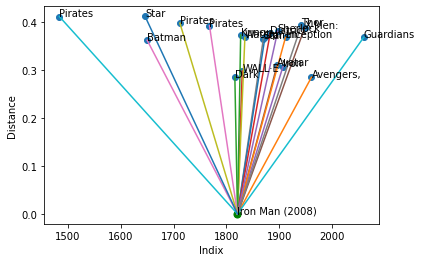

,Movie Name,Distance
0,"Avengers, The (2012)",0.285319
1,"Dark Knight, The (2008)",0.285835
2,WALL·E (2008),0.298138
3,Iron Man 2 (2010),0.307492
4,Avatar (2009),0.310893
5,Batman Begins (2005),0.362759
6,Star Trek (2009),0.366029
7,Watchmen (2009),0.368558
8,Guardians of the Galaxy (2014),0.368758
9,Up (2009),0.368857


In [161]:
movie_name = 'Iron Man'
number_of_movies = 20

recommended, distances, indicies, target_movie = Recommend(knn, movie_name, number_of_movies)
print("Movie:", target_movie)
x, y = indicies.reshape((indicies[0,:].shape[0])), distances.reshape((distances[0,:].shape[0]))
dat = recommended['Movie Name'].tolist()
dat = [item.split("(")[0].split()[0] for item in dat]
dat.insert(0, target_movie)
print(x.shape, y.shape)
print(dat)
vis(x, y, dat)
recommended

## Model Saving

In [14]:
model_dir = os.path.join('..', 'Models')
model_name = 'movies-recommender.knn.pkl'
model_path = os.path.join(model_dir, model_name)

In [69]:
if not os.path.exists(model_dir):
    os.makedirs(model_dir)



In [73]:
knn_file_w = open(model_path, 'wb')
pickle.dump(knn, knn_file_w)
knn_file_w.close()

## Test the Saved Model

In [54]:
k = 20
loaded_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=k, n_jobs=-1)
knn_file_r = open(model_path, 'rb')
loaded_knn = pickle.load(knn_file_r)
knn_file_r.close()

Target Movie Batman Forever (1995)
Target Movie Index 69


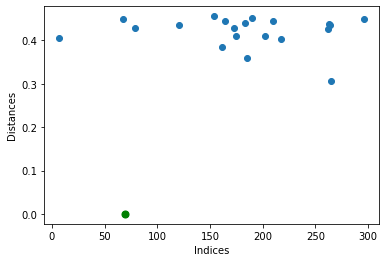

In [87]:
movie_name = 'Batman'
k = 20

recommended, distances, indicies, target_movie = Recommend(loaded_knn, movie_name, k)
vis(indicies, distances)


In [78]:
recommended

,Index,Movie Name,Distance
0,265,Batman (1989),0.305549
1,185,True Lies (1994),0.359396
2,161,Ace Ventura: Pet Detective (1994),0.384173
3,217,Jurassic Park (1993),0.404032
4,7,GoldenEye (1995),0.405572
5,202,Cliffhanger (1993),0.408718
6,175,"Mask, The (1994)",0.409414
7,262,Aladdin (1992),0.426649
8,173,"Lion King, The (1994)",0.427317
9,79,Die Hard: With a Vengeance (1995),0.427554
